# Import das bibliotecas

In [61]:
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import RandomizedPCA
from sklearn.svm import SVC
from sklearn import datasets, neural_network, metrics
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np

# Carrega o dataset de imagens

O dataset escolhido é um conjunto de imagens no formato JPEG de pessoas retiradas da internet. O dataset contem mais de 13.000 imagens, sendo que 1.680 possui mais de 1 foto presente no dataset. Cada imgem esta centrada em uma unica face e é composta pela descrição dos pixels como numeros float RGB entre 0 e 1.0. No dataset também esta presente uma lista com o nome de cada pessoa.

A primeira chamada do dataset é feita pegando apanas pessoas com mais de 70 fotos, ou seja, com bastante conteudo para treino e também garantindo o maximo de pixels possível.

In [62]:
people = fetch_lfw_people(min_faces_per_person=70, resize=1)

In [63]:
n_samples, height, width = people.images.shape

In [64]:
X = people.data
n_features = X.shape[1]

y = people.target
target_names = people.target_names
n_classes = target_names.shape[0]

In [65]:
print ("Numero de imagens:",n_samples,"\nPixels por imagem:",height*width)

Numero de imagens: 1288 
Pixels por imagem: 11750


# Pré processamento

Divide-se a quantidade de imagens para treinamento e para teste utilizando uma funçaõ de divisão randomica.

O atributo "test_size" da função define a porcentagem de imagens para teste.

Utiliza-se o algoritmo RandomizedPCA que faz uma redução linear dos dados, mantendo apenas os mais significativos. 

A variável "n_components" define a quantidade de elementos mantidos.

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
pca = RandomizedPCA(n_components=150,whiten=True).fit(X_train)
eigenfaces = pca.components_.reshape((150, height, width))
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


Podemos plotar algumas imagens, utilizando apenas os pixels que o PCA considerou relevantes para o algoritmo.

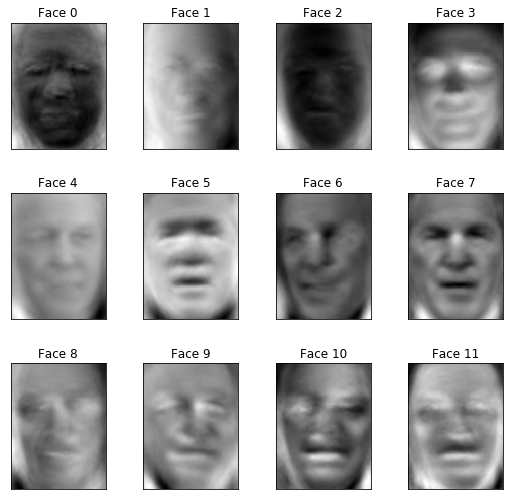

In [67]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99,
                        top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
 
eigenface_titles= []
for i in range(people.images.shape[0]):
    eigenface_titles.append("Face "+str(i))
 
plot_gallery(eigenfaces, eigenface_titles, height, width)
 
plt.show()

# SVC

## Treino 

Agora que temos nossos dados, podemos realizar o treino do algoritmo, assim como a predição. Primeira tentativa foi usando o GridSearchCV que realiza uma busca exaustiva, este por sua vez usa o SVC como estimador. 

In [40]:
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5], 'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf'), param_grid)
clf = clf.fit(X_train_pca, y_train)
y_pred = clf.predict(X_test_pca)

## Avaliação

Utilizando o "classification_report" temos informações sobre os dados obtidos a partir dos dados considerados verdadeiros e os preditos. Abaixo temos dados de precisão para as fotos de cada pessoa em específico e também a média geral.

                   precision    recall  f1-score   support

     Ariel Sharon       0.92      0.61      0.73        18
     Colin Powell       0.83      0.87      0.85        63
  Donald Rumsfeld       0.93      0.87      0.90        30
    George W Bush       0.83      0.95      0.89       124
Gerhard Schroeder       0.96      0.87      0.92        31
      Hugo Chavez       1.00      0.69      0.81        16
       Tony Blair       0.97      0.85      0.91        40

      avg / total       0.88      0.88      0.87       322



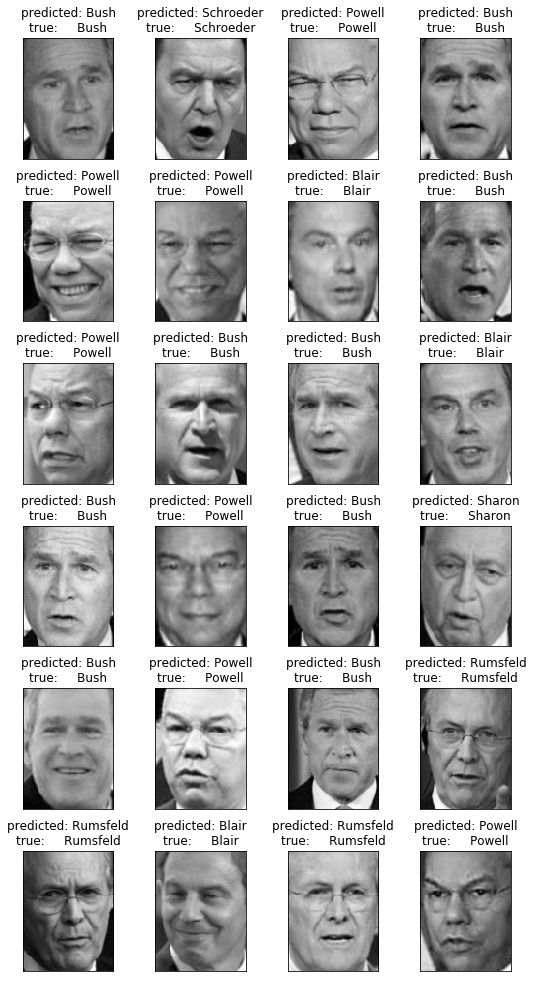

In [41]:
print(classification_report(y_test, y_pred, target_names=target_names))
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:     %s'%(pred_name, true_name)
 
prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, height, width, 6, 4)
plt.show()

## Validação cruzada

In [42]:
scores = cross_val_score(clf,X_train_pca,y_train)
np.mean(scores)

0.75783685579787541

# MLPC

## 10 neuronios

In [43]:
MLPC = neural_network.MLPClassifier(hidden_layer_sizes=(10, ),
activation='relu', # {identity, logistic, tanh, relu},
solver='adam', # {lbfgs, sgd, adam},
alpha=0.0001,
learning_rate='constant', # {constant, invscaling, adaptive},
learning_rate_init=0.001,
power_t=0.5,
max_iter=1000,
shuffle=True,
tol=0.00001,
verbose=True,
momentum=0.9,
validation_fraction=0.1)

In [44]:
MLPC.fit(X_train_pca,y_train)
y_pred = MLPC.predict(X_test_pca)

Iteration 1, loss = 2.31701422
Iteration 2, loss = 2.24524890
Iteration 3, loss = 2.18200593
Iteration 4, loss = 2.12181974
Iteration 5, loss = 2.06402068
Iteration 6, loss = 2.00972574
Iteration 7, loss = 1.95763995
Iteration 8, loss = 1.90884336
Iteration 9, loss = 1.86188306
Iteration 10, loss = 1.81733797
Iteration 11, loss = 1.77503355
Iteration 12, loss = 1.73444404
Iteration 13, loss = 1.69577163
Iteration 14, loss = 1.65823202
Iteration 15, loss = 1.62400269
Iteration 16, loss = 1.58975449
Iteration 17, loss = 1.55674682
Iteration 18, loss = 1.52578011
Iteration 19, loss = 1.49532416
Iteration 20, loss = 1.46632510
Iteration 21, loss = 1.43780778
Iteration 22, loss = 1.40994133
Iteration 23, loss = 1.38327895
Iteration 24, loss = 1.35712547
Iteration 25, loss = 1.33194552
Iteration 26, loss = 1.30655892
Iteration 27, loss = 1.28247314
Iteration 28, loss = 1.25843640
Iteration 29, loss = 1.23455346
Iteration 30, loss = 1.21170129
Iteration 31, loss = 1.18870697
Iteration 32, los

Iteration 290, loss = 0.04984269
Iteration 291, loss = 0.04958113
Iteration 292, loss = 0.04931886
Iteration 293, loss = 0.04905119
Iteration 294, loss = 0.04879024
Iteration 295, loss = 0.04853203
Iteration 296, loss = 0.04827654
Iteration 297, loss = 0.04801850
Iteration 298, loss = 0.04777169
Iteration 299, loss = 0.04752891
Iteration 300, loss = 0.04729326
Iteration 301, loss = 0.04704884
Iteration 302, loss = 0.04680885
Iteration 303, loss = 0.04657380
Iteration 304, loss = 0.04634318
Iteration 305, loss = 0.04610405
Iteration 306, loss = 0.04585684
Iteration 307, loss = 0.04562672
Iteration 308, loss = 0.04539802
Iteration 309, loss = 0.04516622
Iteration 310, loss = 0.04493896
Iteration 311, loss = 0.04470621
Iteration 312, loss = 0.04449484
Iteration 313, loss = 0.04426444
Iteration 314, loss = 0.04404848
Iteration 315, loss = 0.04381862
Iteration 316, loss = 0.04361347
Iteration 317, loss = 0.04340626
Iteration 318, loss = 0.04318010
Iteration 319, loss = 0.04298230
Iteration 

Iteration 541, loss = 0.01962352
Iteration 542, loss = 0.01957536
Iteration 543, loss = 0.01952894
Iteration 544, loss = 0.01948718
Iteration 545, loss = 0.01944120
Iteration 546, loss = 0.01939915
Iteration 547, loss = 0.01935568
Iteration 548, loss = 0.01931510
Iteration 549, loss = 0.01927276
Iteration 550, loss = 0.01923223
Iteration 551, loss = 0.01919175
Iteration 552, loss = 0.01914876
Iteration 553, loss = 0.01910689
Iteration 554, loss = 0.01906175
Iteration 555, loss = 0.01902025
Iteration 556, loss = 0.01897962
Iteration 557, loss = 0.01894151
Iteration 558, loss = 0.01889923
Iteration 559, loss = 0.01885823
Iteration 560, loss = 0.01881805
Iteration 561, loss = 0.01878338
Iteration 562, loss = 0.01874353
Iteration 563, loss = 0.01870364
Iteration 564, loss = 0.01866640
Iteration 565, loss = 0.01862760
Iteration 566, loss = 0.01858761
Iteration 567, loss = 0.01855065
Iteration 568, loss = 0.01851055
Iteration 569, loss = 0.01847305
Iteration 570, loss = 0.01843703
Iteration 

Iteration 792, loss = 0.00854497
Iteration 793, loss = 0.00852301
Iteration 794, loss = 0.00850476
Iteration 795, loss = 0.00848401
Iteration 796, loss = 0.00846695
Iteration 797, loss = 0.00844563
Iteration 798, loss = 0.00842555
Iteration 799, loss = 0.00840730
Iteration 800, loss = 0.00838451
Iteration 801, loss = 0.00836542
Iteration 802, loss = 0.00834397
Iteration 803, loss = 0.00832269
Iteration 804, loss = 0.00830731
Iteration 805, loss = 0.00828592
Iteration 806, loss = 0.00826408
Iteration 807, loss = 0.00824762
Iteration 808, loss = 0.00823084
Iteration 809, loss = 0.00821135
Iteration 810, loss = 0.00819231
Iteration 811, loss = 0.00817486
Iteration 812, loss = 0.00815274
Iteration 813, loss = 0.00813511
Iteration 814, loss = 0.00811897
Iteration 815, loss = 0.00809899
Iteration 816, loss = 0.00807773
Iteration 817, loss = 0.00806115
Iteration 818, loss = 0.00804044
Iteration 819, loss = 0.00802174
Iteration 820, loss = 0.00800239
Iteration 821, loss = 0.00798569
Iteration 

/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


                   precision    recall  f1-score   support

     Ariel Sharon       0.55      0.67      0.60        18
     Colin Powell       0.78      0.78      0.78        63
  Donald Rumsfeld       0.62      0.80      0.70        30
    George W Bush       0.88      0.80      0.84       124
Gerhard Schroeder       0.65      0.77      0.71        31
      Hugo Chavez       0.64      0.56      0.60        16
       Tony Blair       0.80      0.70      0.75        40

      avg / total       0.77      0.76      0.76       322



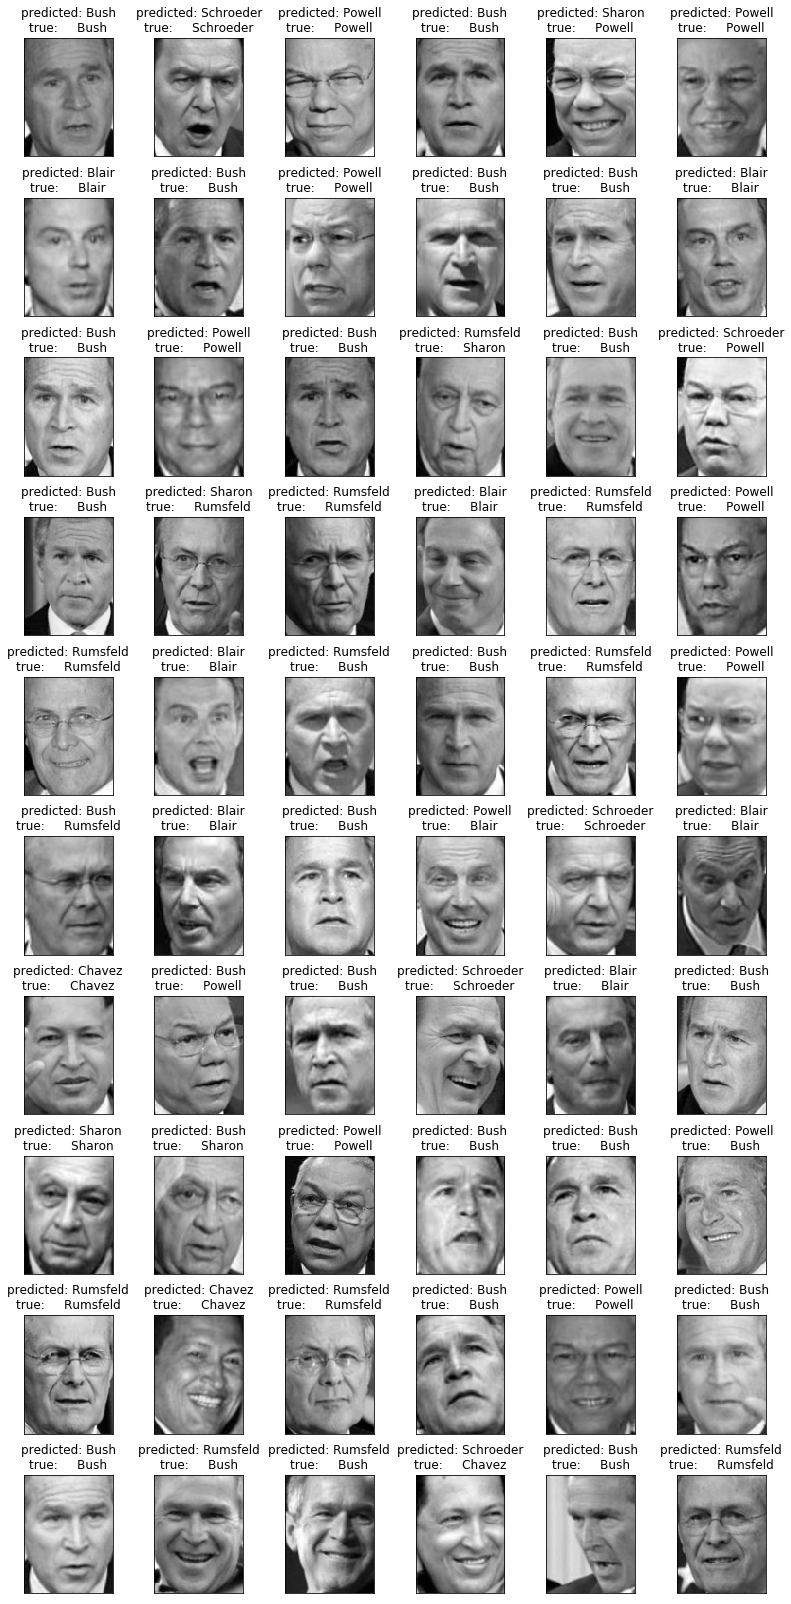

In [45]:
print(classification_report(y_test, y_pred, target_names=target_names))

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:     %s'%(pred_name, true_name)
 
    
prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]
 
plot_gallery(X_test, prediction_titles, height, width ,10, 6)
plt.show()


In [46]:
scores = cross_val_score(MLPC,X_train_pca,y_train)
np.mean(scores)

Iteration 1, loss = 2.21956387
Iteration 2, loss = 2.15237591
Iteration 3, loss = 2.09685498
Iteration 4, loss = 2.04664841
Iteration 5, loss = 1.99699019
Iteration 6, loss = 1.94982323
Iteration 7, loss = 1.90497151
Iteration 8, loss = 1.86248851
Iteration 9, loss = 1.82182505
Iteration 10, loss = 1.78247060
Iteration 11, loss = 1.74528290
Iteration 12, loss = 1.70931955
Iteration 13, loss = 1.67590693
Iteration 14, loss = 1.64264893
Iteration 15, loss = 1.61091538
Iteration 16, loss = 1.58071657
Iteration 17, loss = 1.55207031
Iteration 18, loss = 1.52370808
Iteration 19, loss = 1.49710776
Iteration 20, loss = 1.47140806
Iteration 21, loss = 1.44624218
Iteration 22, loss = 1.42219930
Iteration 23, loss = 1.39879965
Iteration 24, loss = 1.37610744
Iteration 25, loss = 1.35424903
Iteration 26, loss = 1.33343025
Iteration 27, loss = 1.31259495
Iteration 28, loss = 1.29255007
Iteration 29, loss = 1.27371281
Iteration 30, loss = 1.25468232
Iteration 31, loss = 1.23663953
Iteration 32, los

Iteration 263, loss = 0.07312672
Iteration 264, loss = 0.07254140
Iteration 265, loss = 0.07198382
Iteration 266, loss = 0.07141158
Iteration 267, loss = 0.07084772
Iteration 268, loss = 0.07030796
Iteration 269, loss = 0.06974390
Iteration 270, loss = 0.06920482
Iteration 271, loss = 0.06866923
Iteration 272, loss = 0.06809627
Iteration 273, loss = 0.06755131
Iteration 274, loss = 0.06704470
Iteration 275, loss = 0.06655083
Iteration 276, loss = 0.06601990
Iteration 277, loss = 0.06552313
Iteration 278, loss = 0.06501316
Iteration 279, loss = 0.06451190
Iteration 280, loss = 0.06401437
Iteration 281, loss = 0.06353915
Iteration 282, loss = 0.06304473
Iteration 283, loss = 0.06258179
Iteration 284, loss = 0.06210651
Iteration 285, loss = 0.06165083
Iteration 286, loss = 0.06119995
Iteration 287, loss = 0.06074003
Iteration 288, loss = 0.06028966
Iteration 289, loss = 0.05983932
Iteration 290, loss = 0.05938837
Iteration 291, loss = 0.05889713
Iteration 292, loss = 0.05844480
Iteration 

Iteration 541, loss = 0.00977258
Iteration 542, loss = 0.00972335
Iteration 543, loss = 0.00967753
Iteration 544, loss = 0.00963122
Iteration 545, loss = 0.00958450
Iteration 546, loss = 0.00953794
Iteration 547, loss = 0.00949300
Iteration 548, loss = 0.00945019
Iteration 549, loss = 0.00940316
Iteration 550, loss = 0.00936188
Iteration 551, loss = 0.00932042
Iteration 552, loss = 0.00927798
Iteration 553, loss = 0.00923328
Iteration 554, loss = 0.00919062
Iteration 555, loss = 0.00914724
Iteration 556, loss = 0.00910618
Iteration 557, loss = 0.00906386
Iteration 558, loss = 0.00902162
Iteration 559, loss = 0.00898021
Iteration 560, loss = 0.00894019
Iteration 561, loss = 0.00889628
Iteration 562, loss = 0.00885438
Iteration 563, loss = 0.00881524
Iteration 564, loss = 0.00877194
Iteration 565, loss = 0.00873030
Iteration 566, loss = 0.00869125
Iteration 567, loss = 0.00865202
Iteration 568, loss = 0.00861481
Iteration 569, loss = 0.00857242
Iteration 570, loss = 0.00853327
Iteration 

Iteration 827, loss = 0.00355849
Training loss did not improve more than tol=0.000010 for two consecutive epochs. Stopping.
Iteration 1, loss = 2.00537689
Iteration 2, loss = 1.95528208
Iteration 3, loss = 1.91371454
Iteration 4, loss = 1.87381887
Iteration 5, loss = 1.83744718
Iteration 6, loss = 1.80182160
Iteration 7, loss = 1.76787173
Iteration 8, loss = 1.73578325
Iteration 9, loss = 1.70446994
Iteration 10, loss = 1.67481444
Iteration 11, loss = 1.64581897
Iteration 12, loss = 1.61765396
Iteration 13, loss = 1.59082380
Iteration 14, loss = 1.56558187
Iteration 15, loss = 1.54052413
Iteration 16, loss = 1.51650726
Iteration 17, loss = 1.49347629
Iteration 18, loss = 1.47105059
Iteration 19, loss = 1.44908031
Iteration 20, loss = 1.42782710
Iteration 21, loss = 1.40730922
Iteration 22, loss = 1.38707995
Iteration 23, loss = 1.36750684
Iteration 24, loss = 1.34824425
Iteration 25, loss = 1.32887126
Iteration 26, loss = 1.30983579
Iteration 27, loss = 1.29079107
Iteration 28, loss = 

Iteration 291, loss = 0.07068158
Iteration 292, loss = 0.07025450
Iteration 293, loss = 0.06981566
Iteration 294, loss = 0.06940208
Iteration 295, loss = 0.06895948
Iteration 296, loss = 0.06854064
Iteration 297, loss = 0.06810745
Iteration 298, loss = 0.06770462
Iteration 299, loss = 0.06729609
Iteration 300, loss = 0.06691460
Iteration 301, loss = 0.06654699
Iteration 302, loss = 0.06616344
Iteration 303, loss = 0.06578172
Iteration 304, loss = 0.06541958
Iteration 305, loss = 0.06506231
Iteration 306, loss = 0.06469045
Iteration 307, loss = 0.06433467
Iteration 308, loss = 0.06395683
Iteration 309, loss = 0.06361592
Iteration 310, loss = 0.06326519
Iteration 311, loss = 0.06294226
Iteration 312, loss = 0.06262117
Iteration 313, loss = 0.06231965
Iteration 314, loss = 0.06199859
Iteration 315, loss = 0.06168349
Iteration 316, loss = 0.06135894
Iteration 317, loss = 0.06105378
Iteration 318, loss = 0.06073698
Iteration 319, loss = 0.06040966
Iteration 320, loss = 0.06010026
Iteration 

Iteration 582, loss = 0.02390700
Iteration 583, loss = 0.02385292
Iteration 584, loss = 0.02379961
Iteration 585, loss = 0.02374208
Iteration 586, loss = 0.02368081
Iteration 587, loss = 0.02361641
Iteration 588, loss = 0.02355816
Iteration 589, loss = 0.02349516
Iteration 590, loss = 0.02344378
Iteration 591, loss = 0.02336771
Iteration 592, loss = 0.02330755
Iteration 593, loss = 0.02325465
Iteration 594, loss = 0.02319952
Iteration 595, loss = 0.02313844
Iteration 596, loss = 0.02308438
Iteration 597, loss = 0.02303447
Iteration 598, loss = 0.02299272
Iteration 599, loss = 0.02292972
Iteration 600, loss = 0.02287996
Iteration 601, loss = 0.02282294
Iteration 602, loss = 0.02277448
Iteration 603, loss = 0.02271646
Iteration 604, loss = 0.02266413
Iteration 605, loss = 0.02261065
Iteration 606, loss = 0.02256017
Iteration 607, loss = 0.02251466
Iteration 608, loss = 0.02245925
Iteration 609, loss = 0.02240456
Iteration 610, loss = 0.02235827
Iteration 611, loss = 0.02230624
Iteration 

Iteration 870, loss = 0.01202573
Iteration 871, loss = 0.01199598
Iteration 872, loss = 0.01196840
Iteration 873, loss = 0.01194832
Iteration 874, loss = 0.01191619
Iteration 875, loss = 0.01189663
Iteration 876, loss = 0.01186687
Iteration 877, loss = 0.01184817
Iteration 878, loss = 0.01182036
Iteration 879, loss = 0.01179378
Iteration 880, loss = 0.01177162
Iteration 881, loss = 0.01174227
Iteration 882, loss = 0.01171989
Iteration 883, loss = 0.01169737
Iteration 884, loss = 0.01167348
Iteration 885, loss = 0.01164734
Iteration 886, loss = 0.01162601
Iteration 887, loss = 0.01159406
Iteration 888, loss = 0.01157039
Iteration 889, loss = 0.01154013
Iteration 890, loss = 0.01151127
Iteration 891, loss = 0.01148288
Iteration 892, loss = 0.01145501
Iteration 893, loss = 0.01143505
Iteration 894, loss = 0.01141004
Iteration 895, loss = 0.01138893
Iteration 896, loss = 0.01136360
Iteration 897, loss = 0.01134057
Iteration 898, loss = 0.01132093
Iteration 899, loss = 0.01129524
Iteration 

/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 61, loss = 0.75631067
Iteration 62, loss = 0.74493681
Iteration 63, loss = 0.73369707
Iteration 64, loss = 0.72262940
Iteration 65, loss = 0.71185447
Iteration 66, loss = 0.70117675
Iteration 67, loss = 0.69077843
Iteration 68, loss = 0.68041247
Iteration 69, loss = 0.67045559
Iteration 70, loss = 0.66035613
Iteration 71, loss = 0.65078873
Iteration 72, loss = 0.64104206
Iteration 73, loss = 0.63155815
Iteration 74, loss = 0.62215418
Iteration 75, loss = 0.61288440
Iteration 76, loss = 0.60361280
Iteration 77, loss = 0.59453926
Iteration 78, loss = 0.58559232
Iteration 79, loss = 0.57685259
Iteration 80, loss = 0.56836079
Iteration 81, loss = 0.55994374
Iteration 82, loss = 0.55168455
Iteration 83, loss = 0.54341191
Iteration 84, loss = 0.53520362
Iteration 85, loss = 0.52739121
Iteration 86, loss = 0.51973305
Iteration 87, loss = 0.51211093
Iteration 88, loss = 0.50461176
Iteration 89, loss = 0.49712329
Iteration 90, loss = 0.48989570
Iteration 91, loss = 0.48285795
Iteratio

Iteration 348, loss = 0.03648298
Iteration 349, loss = 0.03629721
Iteration 350, loss = 0.03610686
Iteration 351, loss = 0.03591999
Iteration 352, loss = 0.03573932
Iteration 353, loss = 0.03556520
Iteration 354, loss = 0.03540354
Iteration 355, loss = 0.03524027
Iteration 356, loss = 0.03507625
Iteration 357, loss = 0.03491256
Iteration 358, loss = 0.03475338
Iteration 359, loss = 0.03458692
Iteration 360, loss = 0.03441144
Iteration 361, loss = 0.03426390
Iteration 362, loss = 0.03410046
Iteration 363, loss = 0.03393793
Iteration 364, loss = 0.03377717
Iteration 365, loss = 0.03362616
Iteration 366, loss = 0.03346436
Iteration 367, loss = 0.03331570
Iteration 368, loss = 0.03316413
Iteration 369, loss = 0.03301444
Iteration 370, loss = 0.03286506
Iteration 371, loss = 0.03270944
Iteration 372, loss = 0.03256838
Iteration 373, loss = 0.03241674
Iteration 374, loss = 0.03227893
Iteration 375, loss = 0.03215307
Iteration 376, loss = 0.03200454
Iteration 377, loss = 0.03187417
Iteration 

Iteration 629, loss = 0.01283165
Iteration 630, loss = 0.01279746
Iteration 631, loss = 0.01275267
Iteration 632, loss = 0.01271417
Iteration 633, loss = 0.01267626
Iteration 634, loss = 0.01264296
Iteration 635, loss = 0.01260845
Iteration 636, loss = 0.01257582
Iteration 637, loss = 0.01254399
Iteration 638, loss = 0.01251160
Iteration 639, loss = 0.01248785
Iteration 640, loss = 0.01245667
Iteration 641, loss = 0.01242817
Iteration 642, loss = 0.01239766
Iteration 643, loss = 0.01236508
Iteration 644, loss = 0.01233626
Iteration 645, loss = 0.01230338
Iteration 646, loss = 0.01227098
Iteration 647, loss = 0.01223753
Iteration 648, loss = 0.01220549
Iteration 649, loss = 0.01217583
Iteration 650, loss = 0.01214393
Iteration 651, loss = 0.01211375
Iteration 652, loss = 0.01208543
Iteration 653, loss = 0.01205325
Iteration 654, loss = 0.01202224
Iteration 655, loss = 0.01198910
Iteration 656, loss = 0.01195748
Iteration 657, loss = 0.01192707
Iteration 658, loss = 0.01189825
Iteration 

0.70925618110025912

## 10000 neuronios

Iteration 1, loss = 1.50472120
Iteration 2, loss = 0.45578958
Iteration 3, loss = 0.17147299
Iteration 4, loss = 0.06742111
Iteration 5, loss = 0.03440411
Iteration 6, loss = 0.01857272
Iteration 7, loss = 0.01119634
Iteration 8, loss = 0.00800646
Iteration 9, loss = 0.00614589
Iteration 10, loss = 0.00505532
Iteration 11, loss = 0.00429479
Iteration 12, loss = 0.00376631
Iteration 13, loss = 0.00338635
Iteration 14, loss = 0.00310152
Iteration 15, loss = 0.00286949
Iteration 16, loss = 0.00267370
Iteration 17, loss = 0.00251329
Iteration 18, loss = 0.00236886
Iteration 19, loss = 0.00224178
Iteration 20, loss = 0.00212917
Iteration 21, loss = 0.00202753
Iteration 22, loss = 0.00193078
Iteration 23, loss = 0.00184445
Iteration 24, loss = 0.00176389
Iteration 25, loss = 0.00169003
Iteration 26, loss = 0.00162038
Iteration 27, loss = 0.00155569
Iteration 28, loss = 0.00149508
Iteration 29, loss = 0.00143964
Iteration 30, loss = 0.00138594
Iteration 31, loss = 0.00133627
Iteration 32, los

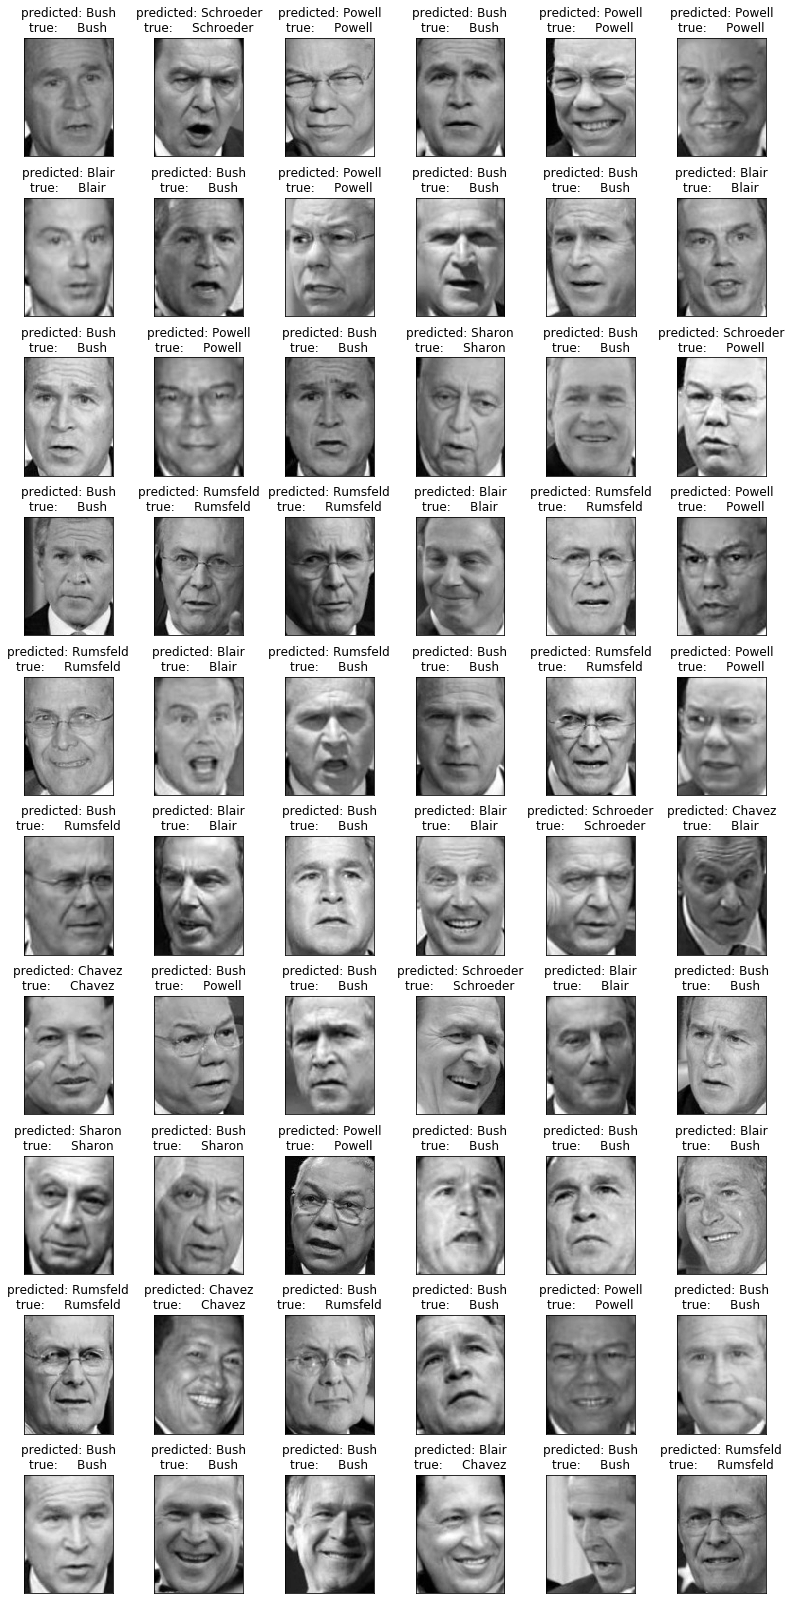

In [47]:
MLPC = neural_network.MLPClassifier(hidden_layer_sizes=(10000,),
activation='relu', # {identity, logistic, tanh, relu},
solver='adam', # {lbfgs, sgd, adam},
alpha=0.0001,
learning_rate='constant', # {constant, invscaling, adaptive},
learning_rate_init=0.001,
power_t=0.5,
max_iter=1000,
shuffle=True,
tol=0.00001,
verbose=True,
momentum=0.9,
validation_fraction=0.1)


MLPC.fit(X_train_pca,y_train)
y_pred = MLPC.predict(X_test_pca)


print(classification_report(y_test, y_pred, target_names=target_names))
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:     %s'%(pred_name, true_name)
 
prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]
 
plot_gallery(X_test, prediction_titles, height, width ,10, 6)
plt.show()

In [48]:
scores = cross_val_score(MLPC,X_train_pca,y_train)
np.mean(scores)

Iteration 1, loss = 1.71104161
Iteration 2, loss = 0.55558112
Iteration 3, loss = 0.24378881
Iteration 4, loss = 0.12082333
Iteration 5, loss = 0.06460555
Iteration 6, loss = 0.03695460
Iteration 7, loss = 0.02179807
Iteration 8, loss = 0.01362558
Iteration 9, loss = 0.00959073
Iteration 10, loss = 0.00728264
Iteration 11, loss = 0.00593267
Iteration 12, loss = 0.00503346
Iteration 13, loss = 0.00436739
Iteration 14, loss = 0.00390050
Iteration 15, loss = 0.00352938
Iteration 16, loss = 0.00323467
Iteration 17, loss = 0.00299306
Iteration 18, loss = 0.00280441
Iteration 19, loss = 0.00263998
Iteration 20, loss = 0.00249981
Iteration 21, loss = 0.00237819
Iteration 22, loss = 0.00226972
Iteration 23, loss = 0.00217588
Iteration 24, loss = 0.00208615
Iteration 25, loss = 0.00200116
Iteration 26, loss = 0.00192658
Iteration 27, loss = 0.00185393
Iteration 28, loss = 0.00178855
Iteration 29, loss = 0.00172549
Iteration 30, loss = 0.00166581
Iteration 31, loss = 0.00161220
Iteration 32, los

0.76814068490230414

## 10000 neuronios e tolerancia aumentada 100x

Iteration 1, loss = 1.55747014
Iteration 2, loss = 0.46792955
Iteration 3, loss = 0.17718399
Iteration 4, loss = 0.07890524
Iteration 5, loss = 0.03569220
Iteration 6, loss = 0.01958745
Iteration 7, loss = 0.01287245
Iteration 8, loss = 0.00920742
Iteration 9, loss = 0.00691226
Iteration 10, loss = 0.00551851
Iteration 11, loss = 0.00467078
Iteration 12, loss = 0.00407899
Iteration 13, loss = 0.00365276
Iteration 14, loss = 0.00335385
Iteration 15, loss = 0.00308982
Iteration 16, loss = 0.00287783
Iteration 17, loss = 0.00269795
Iteration 18, loss = 0.00253815
Iteration 19, loss = 0.00240036
Iteration 20, loss = 0.00227506
Iteration 21, loss = 0.00216287
Iteration 22, loss = 0.00205997
Iteration 23, loss = 0.00196355
Iteration 24, loss = 0.00187768
Iteration 25, loss = 0.00179656
Iteration 26, loss = 0.00172155
Iteration 27, loss = 0.00165237
Iteration 28, loss = 0.00158562
Iteration 29, loss = 0.00152595
Iteration 30, loss = 0.00146855
Iteration 31, loss = 0.00141540
Iteration 32, los

Iteration 253, loss = 0.00018753
Iteration 254, loss = 0.00018722
Iteration 255, loss = 0.00018689
Iteration 256, loss = 0.00018658
Iteration 257, loss = 0.00018627
Iteration 258, loss = 0.00018596
Iteration 259, loss = 0.00018565
Iteration 260, loss = 0.00018536
Iteration 261, loss = 0.00018506
Iteration 262, loss = 0.00018476
Iteration 263, loss = 0.00018447
Iteration 264, loss = 0.00018418
Iteration 265, loss = 0.00018389
Iteration 266, loss = 0.00018361
Iteration 267, loss = 0.00018332
Iteration 268, loss = 0.00018305
Iteration 269, loss = 0.00018278
Iteration 270, loss = 0.00018250
Iteration 271, loss = 0.00018223
Iteration 272, loss = 0.00018197
Iteration 273, loss = 0.00018170
Iteration 274, loss = 0.00018144
Iteration 275, loss = 0.00018118
Iteration 276, loss = 0.00018092
Iteration 277, loss = 0.00018067
Iteration 278, loss = 0.00018041
Iteration 279, loss = 0.00018017
Iteration 280, loss = 0.00017992
Iteration 281, loss = 0.00017967
Iteration 282, loss = 0.00017943
Iteration 

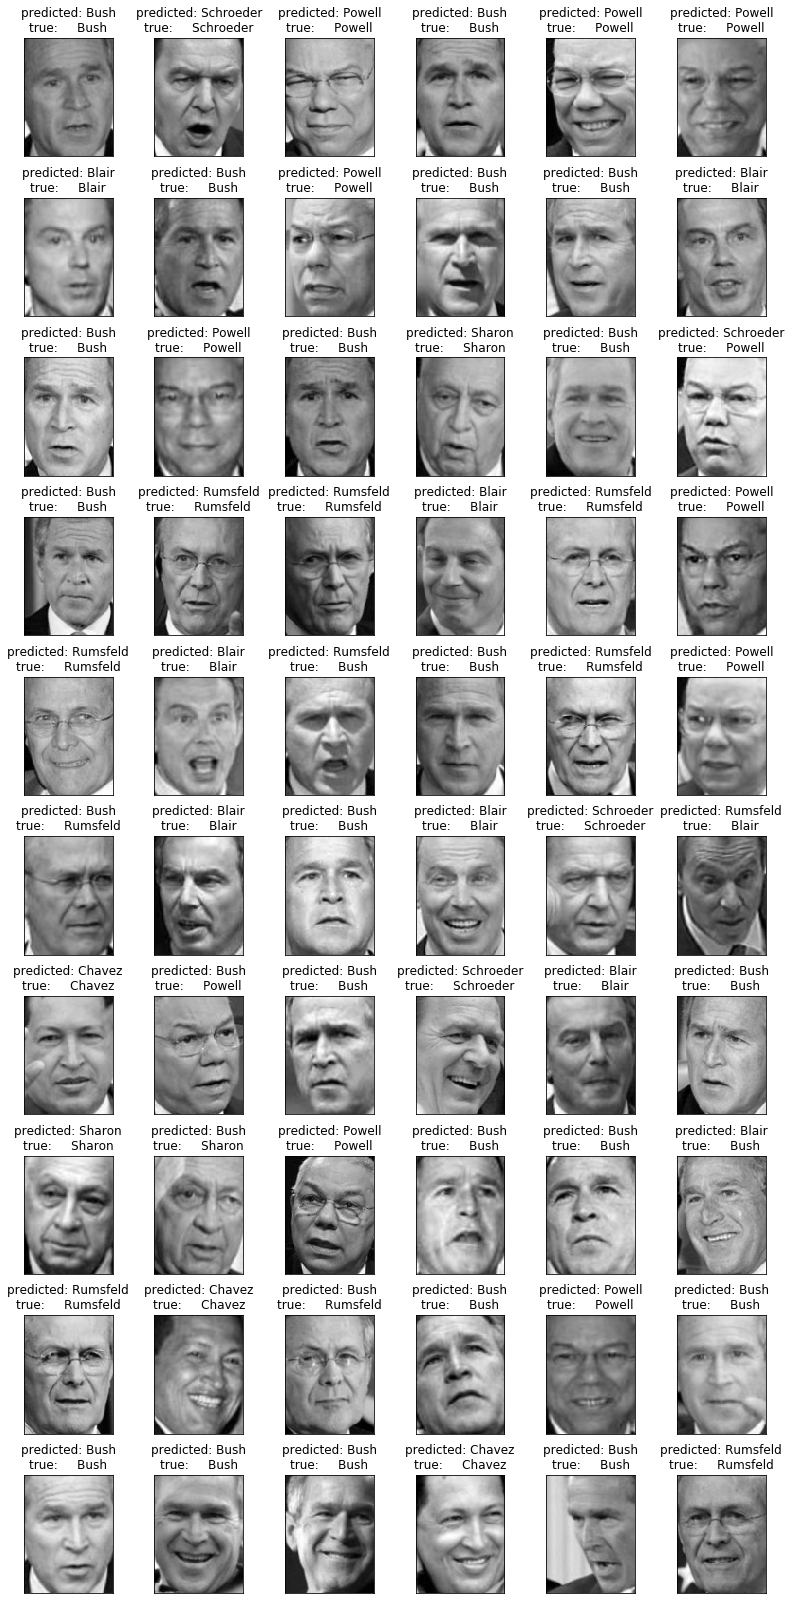

In [49]:
MLPC = neural_network.MLPClassifier(hidden_layer_sizes=(10000, ),
activation='relu', # {identity, logistic, tanh, relu},
solver='adam', # {lbfgs, sgd, adam},
alpha=0.0001,
learning_rate='constant', # {constant, invscaling, adaptive},
learning_rate_init=0.001,
power_t=0.5,
max_iter=1000,
shuffle=True,
tol=0.0000001,
verbose=True,
momentum=0.9,
validation_fraction=0.1)


MLPC.fit(X_train_pca,y_train)
y_pred = MLPC.predict(X_test_pca)


print(classification_report(y_test, y_pred, target_names=target_names))
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:     %s'%(pred_name, true_name)
 
prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]
 
plot_gallery(X_test, prediction_titles, height, width ,10, 6)
plt.show()

In [50]:
scores = cross_val_score(MLPC,X_train_pca,y_train)
np.mean(scores)

Iteration 1, loss = 1.65153748
Iteration 2, loss = 0.53423193
Iteration 3, loss = 0.23539776
Iteration 4, loss = 0.11413097
Iteration 5, loss = 0.05425958
Iteration 6, loss = 0.03088322
Iteration 7, loss = 0.01872983
Iteration 8, loss = 0.01251005
Iteration 9, loss = 0.00852392
Iteration 10, loss = 0.00634669
Iteration 11, loss = 0.00508870
Iteration 12, loss = 0.00428561
Iteration 13, loss = 0.00373276
Iteration 14, loss = 0.00333481
Iteration 15, loss = 0.00305044
Iteration 16, loss = 0.00279295
Iteration 17, loss = 0.00259463
Iteration 18, loss = 0.00241922
Iteration 19, loss = 0.00227766
Iteration 20, loss = 0.00215393
Iteration 21, loss = 0.00205370
Iteration 22, loss = 0.00195977
Iteration 23, loss = 0.00187431
Iteration 24, loss = 0.00179472
Iteration 25, loss = 0.00172747
Iteration 26, loss = 0.00166232
Iteration 27, loss = 0.00160207
Iteration 28, loss = 0.00154836
Iteration 29, loss = 0.00149566
Iteration 30, loss = 0.00144745
Iteration 31, loss = 0.00140128
Iteration 32, los

Iteration 253, loss = 0.00021693
Iteration 254, loss = 0.00021652
Iteration 255, loss = 0.00021612
Iteration 256, loss = 0.00021573
Iteration 257, loss = 0.00021535
Iteration 258, loss = 0.00021496
Iteration 259, loss = 0.00021458
Iteration 260, loss = 0.00021421
Iteration 261, loss = 0.00021383
Iteration 262, loss = 0.00021347
Iteration 263, loss = 0.00021311
Iteration 264, loss = 0.00021274
Iteration 265, loss = 0.00021238
Iteration 266, loss = 0.00021203
Iteration 267, loss = 0.00021169
Iteration 268, loss = 0.00021133
Iteration 269, loss = 0.00021098
Iteration 270, loss = 0.00021065
Iteration 271, loss = 0.00021029
Iteration 272, loss = 0.00020995
Iteration 273, loss = 0.00020961
Iteration 274, loss = 0.00020928
Iteration 275, loss = 0.00020895
Iteration 276, loss = 0.00020863
Iteration 277, loss = 0.00020831
Iteration 278, loss = 0.00020799
Iteration 279, loss = 0.00020767
Iteration 280, loss = 0.00020736
Iteration 281, loss = 0.00020705
Iteration 282, loss = 0.00020675
Iteration 

Iteration 31, loss = 0.00141633
Iteration 32, loss = 0.00137248
Iteration 33, loss = 0.00132922
Iteration 34, loss = 0.00128894
Iteration 35, loss = 0.00125001
Iteration 36, loss = 0.00121473
Iteration 37, loss = 0.00117927
Iteration 38, loss = 0.00114825
Iteration 39, loss = 0.00111666
Iteration 40, loss = 0.00108822
Iteration 41, loss = 0.00105952
Iteration 42, loss = 0.00103312
Iteration 43, loss = 0.00100775
Iteration 44, loss = 0.00098294
Iteration 45, loss = 0.00095979
Iteration 46, loss = 0.00093730
Iteration 47, loss = 0.00091601
Iteration 48, loss = 0.00089569
Iteration 49, loss = 0.00087622
Iteration 50, loss = 0.00085802
Iteration 51, loss = 0.00084010
Iteration 52, loss = 0.00082328
Iteration 53, loss = 0.00080677
Iteration 54, loss = 0.00079136
Iteration 55, loss = 0.00077610
Iteration 56, loss = 0.00076111
Iteration 57, loss = 0.00074685
Iteration 58, loss = 0.00073311
Iteration 59, loss = 0.00071984
Iteration 60, loss = 0.00070673
Iteration 61, loss = 0.00069405
Iteratio

Iteration 282, loss = 0.00020549
Iteration 283, loss = 0.00020520
Iteration 284, loss = 0.00020490
Iteration 285, loss = 0.00020460
Iteration 286, loss = 0.00020431
Iteration 287, loss = 0.00020403
Iteration 288, loss = 0.00020374
Iteration 289, loss = 0.00020346
Iteration 290, loss = 0.00020318
Iteration 291, loss = 0.00020290
Iteration 292, loss = 0.00020263
Iteration 293, loss = 0.00020237
Iteration 294, loss = 0.00020209
Iteration 295, loss = 0.00020182
Iteration 296, loss = 0.00020157
Iteration 297, loss = 0.00020130
Iteration 298, loss = 0.00020105
Iteration 299, loss = 0.00020079
Iteration 300, loss = 0.00020054
Iteration 301, loss = 0.00020029
Iteration 302, loss = 0.00020004
Iteration 303, loss = 0.00019979
Iteration 304, loss = 0.00019954
Iteration 305, loss = 0.00019930
Iteration 306, loss = 0.00019906
Iteration 307, loss = 0.00019882
Iteration 308, loss = 0.00019858
Iteration 309, loss = 0.00019835
Iteration 310, loss = 0.00019812
Iteration 311, loss = 0.00019790
Iteration 

Iteration 71, loss = 0.00051749
Iteration 72, loss = 0.00051058
Iteration 73, loss = 0.00050361
Iteration 74, loss = 0.00049709
Iteration 75, loss = 0.00049073
Iteration 76, loss = 0.00048454
Iteration 77, loss = 0.00047860
Iteration 78, loss = 0.00047282
Iteration 79, loss = 0.00046710
Iteration 80, loss = 0.00046167
Iteration 81, loss = 0.00045633
Iteration 82, loss = 0.00045117
Iteration 83, loss = 0.00044614
Iteration 84, loss = 0.00044131
Iteration 85, loss = 0.00043641
Iteration 86, loss = 0.00043171
Iteration 87, loss = 0.00042716
Iteration 88, loss = 0.00042266
Iteration 89, loss = 0.00041843
Iteration 90, loss = 0.00041428
Iteration 91, loss = 0.00041018
Iteration 92, loss = 0.00040618
Iteration 93, loss = 0.00040220
Iteration 94, loss = 0.00039835
Iteration 95, loss = 0.00039460
Iteration 96, loss = 0.00039093
Iteration 97, loss = 0.00038729
Iteration 98, loss = 0.00038373
Iteration 99, loss = 0.00038040
Iteration 100, loss = 0.00037701
Iteration 101, loss = 0.00037376
Iterat

Iteration 321, loss = 0.00018758
Iteration 322, loss = 0.00018739
Iteration 323, loss = 0.00018720
Iteration 324, loss = 0.00018701
Iteration 325, loss = 0.00018682
Iteration 326, loss = 0.00018663
Iteration 327, loss = 0.00018645
Iteration 328, loss = 0.00018627
Iteration 329, loss = 0.00018610
Iteration 330, loss = 0.00018592
Iteration 331, loss = 0.00018575
Iteration 332, loss = 0.00018558
Iteration 333, loss = 0.00018540
Iteration 334, loss = 0.00018523
Iteration 335, loss = 0.00018506
Iteration 336, loss = 0.00018489
Iteration 337, loss = 0.00018472
Iteration 338, loss = 0.00018455
Iteration 339, loss = 0.00018438
Iteration 340, loss = 0.00018421
Iteration 341, loss = 0.00018405
Iteration 342, loss = 0.00018388
Iteration 343, loss = 0.00018372
Iteration 344, loss = 0.00018356
Iteration 345, loss = 0.00018340
Iteration 346, loss = 0.00018324
Iteration 347, loss = 0.00018308
Iteration 348, loss = 0.00018293
Iteration 349, loss = 0.00018277
Iteration 350, loss = 0.00018261
Iteration 

0.78575939802326611

## Sem pre-processamento

Iteration 1, loss = 18.49981064
Iteration 2, loss = 16.47385112
Iteration 3, loss = 16.05657622
Iteration 4, loss = 17.30126633
Iteration 5, loss = 16.52169661
Iteration 6, loss = 18.12743706
Training loss did not improve more than tol=0.000010 for two consecutive epochs. Stopping.


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                   precision    recall  f1-score   support

     Ariel Sharon       0.00      0.00      0.00        21
     Colin Powell       1.00      0.04      0.07        52
  Donald Rumsfeld       0.00      0.00      0.00        39
    George W Bush       0.40      1.00      0.57       127
Gerhard Schroeder       0.00      0.00      0.00        27
      Hugo Chavez       0.00      0.00      0.00        15
       Tony Blair       0.00      0.00      0.00        41

      avg / total       0.32      0.40      0.24       322



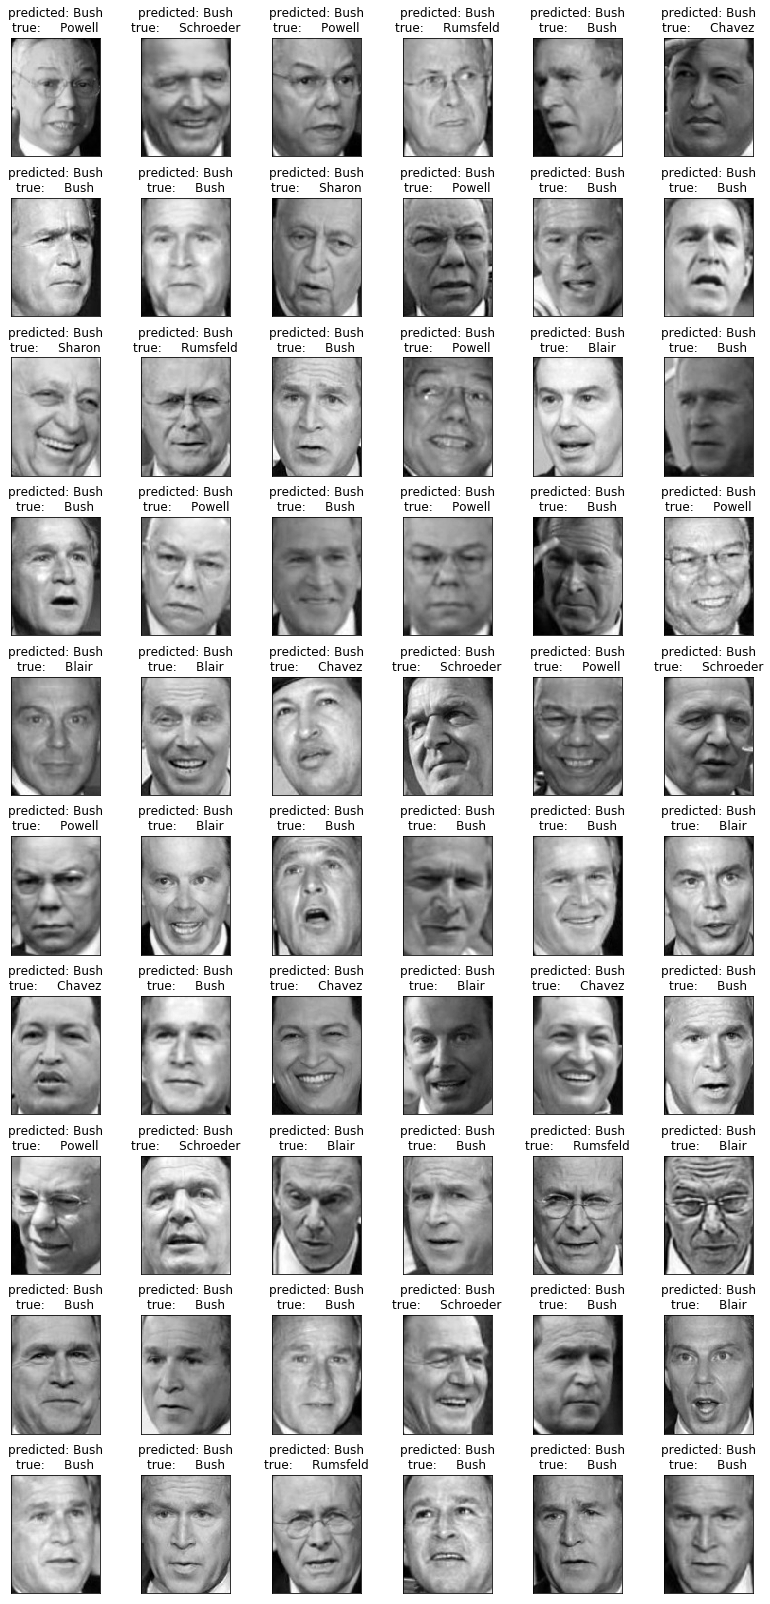

In [68]:
MLPC = neural_network.MLPClassifier(hidden_layer_sizes=(10000, ),
activation='relu', # {identity, logistic, tanh, relu},
solver='adam', # {lbfgs, sgd, adam},
alpha=0.0001,
learning_rate='constant', # {constant, invscaling, adaptive},
learning_rate_init=0.001,
power_t=0.5,
max_iter=1000,
shuffle=True,
tol=0.00001,
verbose=True,
momentum=0.9,
validation_fraction=0.1)


MLPC.fit(X_train,y_train)
y_pred = MLPC.predict(X_test)


print(classification_report(y_test, y_pred, target_names=target_names))
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:     %s'%(pred_name, true_name)
 
prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]
 
plot_gallery(X_test, prediction_titles, height, width ,10, 6)
plt.show()

In [69]:
scores = cross_val_score(MLPC,X_train,y_train)
np.mean(scores)

Iteration 1, loss = 17.18488299
Iteration 2, loss = 20.65485684
Iteration 3, loss = 13.38739937
Iteration 4, loss = 17.27305580
Iteration 5, loss = 20.93660422
Iteration 6, loss = 15.72605844
Training loss did not improve more than tol=0.000010 for two consecutive epochs. Stopping.
Iteration 1, loss = 17.52784293
Iteration 2, loss = 18.70977490
Iteration 3, loss = 17.35330614
Iteration 4, loss = 13.42648295
Iteration 5, loss = 21.03042036
Iteration 6, loss = 19.84203201
Iteration 7, loss = 12.48369634
Iteration 8, loss = 16.58005266
Iteration 9, loss = 15.31332097
Iteration 10, loss = 10.74666397
Iteration 11, loss = 14.98144966
Iteration 12, loss = 11.22972206
Iteration 13, loss = 14.72911342
Training loss did not improve more than tol=0.000010 for two consecutive epochs. Stopping.
Iteration 1, loss = 17.46959610
Iteration 2, loss = 21.35823268
Iteration 3, loss = 13.45611216
Iteration 4, loss = 13.26128459
Iteration 5, loss = 18.97254905
Iteration 6, loss = 21.10792531
Iteration 7, l

0.42239831074206674

## Com 4x componentes no pre processamento

Anteriormente foram mantidos 150 componentes pelo PCA no pre processamento. Este sera refeito com o dobro de componentes para ver como afeta o resultado.

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
pca = RandomizedPCA(n_components=600,whiten=True).fit(X_train)
eigenfaces = pca.components_.reshape((600, height, width))
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


Iteration 1, loss = 1.84255418
Iteration 2, loss = 0.20631408
Iteration 3, loss = 0.00952780
Iteration 4, loss = 0.00376305
Iteration 5, loss = 0.00280406
Iteration 6, loss = 0.00217216
Iteration 7, loss = 0.00165281
Iteration 8, loss = 0.00129186
Iteration 9, loss = 0.00107283
Iteration 10, loss = 0.00092388
Iteration 11, loss = 0.00081634
Iteration 12, loss = 0.00074563
Iteration 13, loss = 0.00069671
Iteration 14, loss = 0.00065942
Iteration 15, loss = 0.00063230
Iteration 16, loss = 0.00061018
Iteration 17, loss = 0.00059335
Iteration 18, loss = 0.00057908
Iteration 19, loss = 0.00056615
Iteration 20, loss = 0.00055545
Iteration 21, loss = 0.00054649
Iteration 22, loss = 0.00053806
Iteration 23, loss = 0.00053055
Training loss did not improve more than tol=0.000010 for two consecutive epochs. Stopping.
                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.38      0.55        16
     Colin Powell       0.86      0.40      0.55        62
  Do

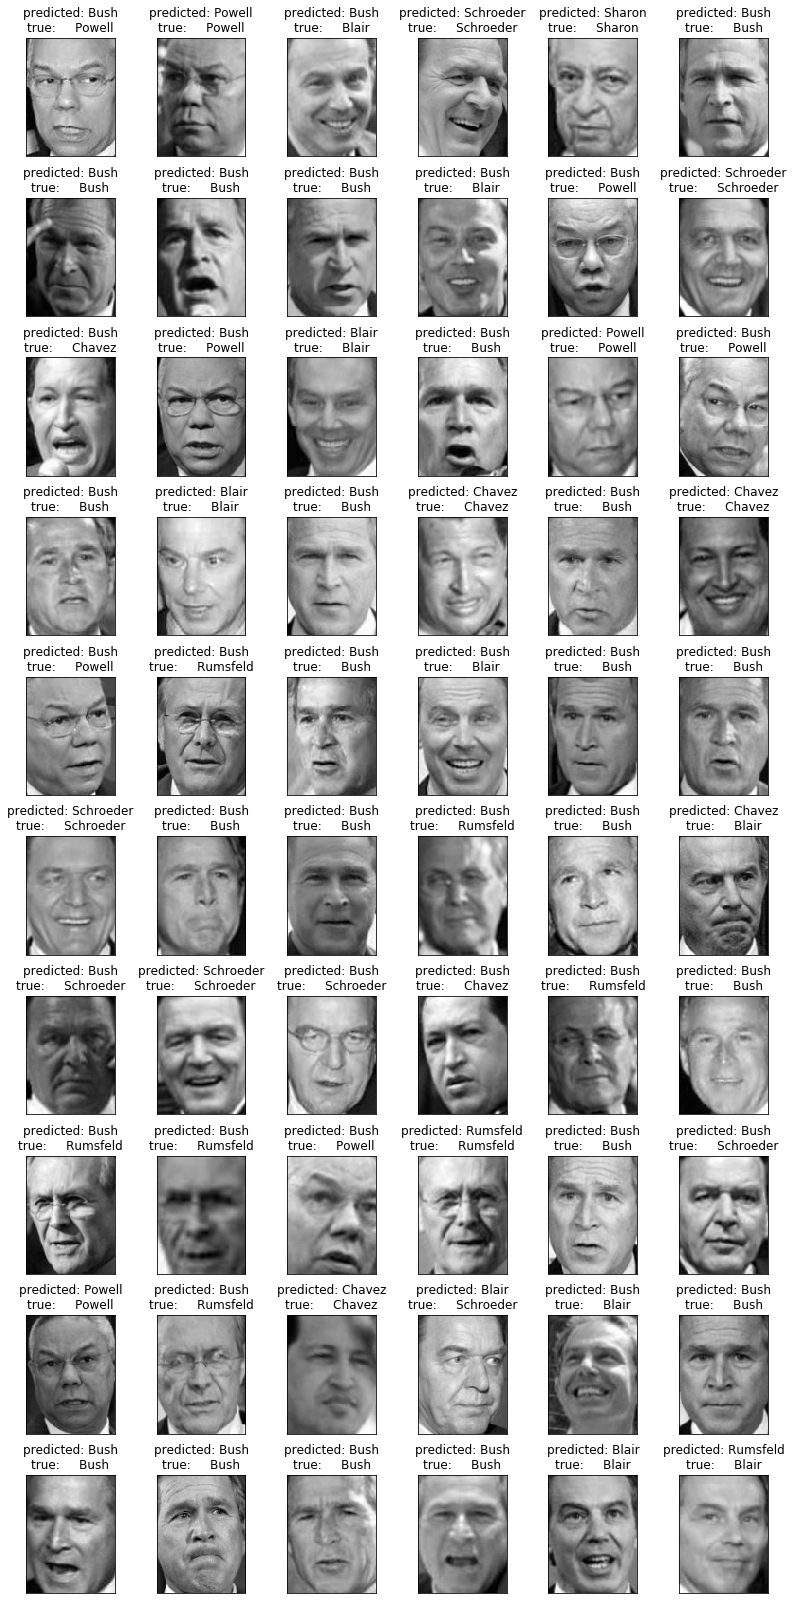

In [71]:
MLPC = neural_network.MLPClassifier(hidden_layer_sizes=(10000, ),
activation='relu', # {identity, logistic, tanh, relu},
solver='adam', # {lbfgs, sgd, adam},
alpha=0.0001,
learning_rate='constant', # {constant, invscaling, adaptive},
learning_rate_init=0.001,
power_t=0.5,
max_iter=1000,
shuffle=True,
tol=0.00001,
verbose=True,
momentum=0.9,
validation_fraction=0.1)


MLPC.fit(X_train_pca,y_train)
y_pred = MLPC.predict(X_test_pca)


print(classification_report(y_test, y_pred, target_names=target_names))
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:     %s'%(pred_name, true_name)
 
prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]
 
plot_gallery(X_test, prediction_titles, height, width ,10, 6)
plt.show()

In [72]:
scores = cross_val_score(MLPC,X_train_pca,y_train)
np.mean(scores)

Iteration 1, loss = 1.87423818
Iteration 2, loss = 0.13982953
Iteration 3, loss = 0.02391553
Iteration 4, loss = 0.00683877
Iteration 5, loss = 0.00329212
Iteration 6, loss = 0.00214178
Iteration 7, loss = 0.00153992
Iteration 8, loss = 0.00118423
Iteration 9, loss = 0.00100596
Iteration 10, loss = 0.00089891
Iteration 11, loss = 0.00082597
Iteration 12, loss = 0.00077209
Iteration 13, loss = 0.00073819
Iteration 14, loss = 0.00070998
Iteration 15, loss = 0.00068978
Iteration 16, loss = 0.00067307
Iteration 17, loss = 0.00065954
Iteration 18, loss = 0.00064857
Iteration 19, loss = 0.00063972
Iteration 20, loss = 0.00063130
Iteration 21, loss = 0.00062412
Training loss did not improve more than tol=0.000010 for two consecutive epochs. Stopping.
Iteration 1, loss = 1.86241410
Iteration 2, loss = 0.20332771
Iteration 3, loss = 0.02467433
Iteration 4, loss = 0.00501175
Iteration 5, loss = 0.00248055
Iteration 6, loss = 0.00183937
Iteration 7, loss = 0.00158468
Iteration 8, loss = 0.0013745

0.45028075843236798

## Recarregar o dataset permitindo pessoas com menor quantidade de imagens

In [56]:
people = fetch_lfw_people(min_faces_per_person=10, resize=1)

In [57]:
n_samples, height, width = people.images.shape

X = people.data
n_features = X.shape[1]

y = people.target
target_names = people.target_names
n_classes = target_names.shape[0]
print ("Numero de imagens:",n_samples,"\nPixels por imagem:",height*width)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
pca = RandomizedPCA(n_components=150,whiten=True).fit(X_train)
eigenfaces = pca.components_.reshape((150, height, width))
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

Numero de imagens: 4324 
Pixels por imagem: 11750


/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


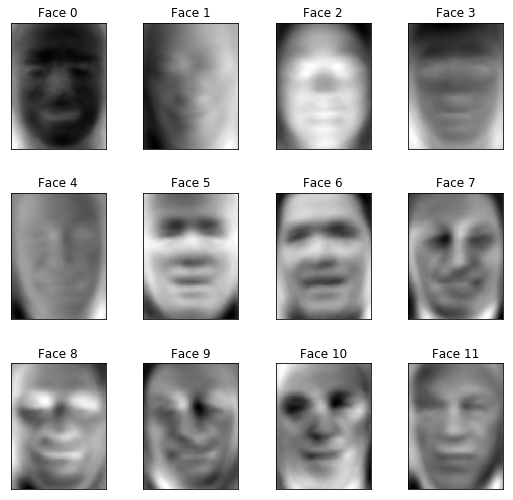

In [58]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99,
                        top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
 
eigenface_titles= []
for i in range(people.images.shape[0]):
    eigenface_titles.append("Face "+str(i))
 
plot_gallery(eigenfaces, eigenface_titles, height, width)
 
plt.show()

Iteration 1, loss = 4.21003292
Iteration 2, loss = 1.71551266
Iteration 3, loss = 0.63381398
Iteration 4, loss = 0.22728987
Iteration 5, loss = 0.09393021
Iteration 6, loss = 0.04634622
Iteration 7, loss = 0.03062138
Iteration 8, loss = 0.02257922
Iteration 9, loss = 0.01804346
Iteration 10, loss = 0.01492818
Iteration 11, loss = 0.01269909
Iteration 12, loss = 0.01098557
Iteration 13, loss = 0.00968241
Iteration 14, loss = 0.00860951
Iteration 15, loss = 0.00771668
Iteration 16, loss = 0.00697242
Iteration 17, loss = 0.00634378
Iteration 18, loss = 0.00581308
Iteration 19, loss = 0.00535676
Iteration 20, loss = 0.00495939
Iteration 21, loss = 0.00461545
Iteration 22, loss = 0.00430794
Iteration 23, loss = 0.00404092
Iteration 24, loss = 0.00379215
Iteration 25, loss = 0.00357667
Iteration 26, loss = 0.00338558
Iteration 27, loss = 0.00321332
Iteration 28, loss = 0.00305005
Iteration 29, loss = 0.00290678
Iteration 30, loss = 0.00277216
Iteration 31, loss = 0.00265343
Iteration 32, los

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


                           precision    recall  f1-score   support

             Abdullah Gul       0.33      1.00      0.50         1
             Adrien Brody       1.00      1.00      1.00         1
         Alejandro Toledo       0.73      0.53      0.62        15
             Alvaro Uribe       0.64      0.58      0.61        12
          Amelie Mauresmo       0.80      0.67      0.73         6
             Andre Agassi       0.57      0.40      0.47        10
             Andy Roddick       1.00      0.33      0.50         6
           Angelina Jolie       0.50      0.33      0.40         3
              Ann Veneman       0.50      0.33      0.40         3
          Anna Kournikova       0.00      0.00      0.00         1
            Ari Fleischer       1.00      1.00      1.00         2
             Ariel Sharon       0.48      0.71      0.57        17
    Arnold Schwarzenegger       0.27      0.33      0.30         9
     Atal Bihari Vajpayee       0.43      0.50      0.46     

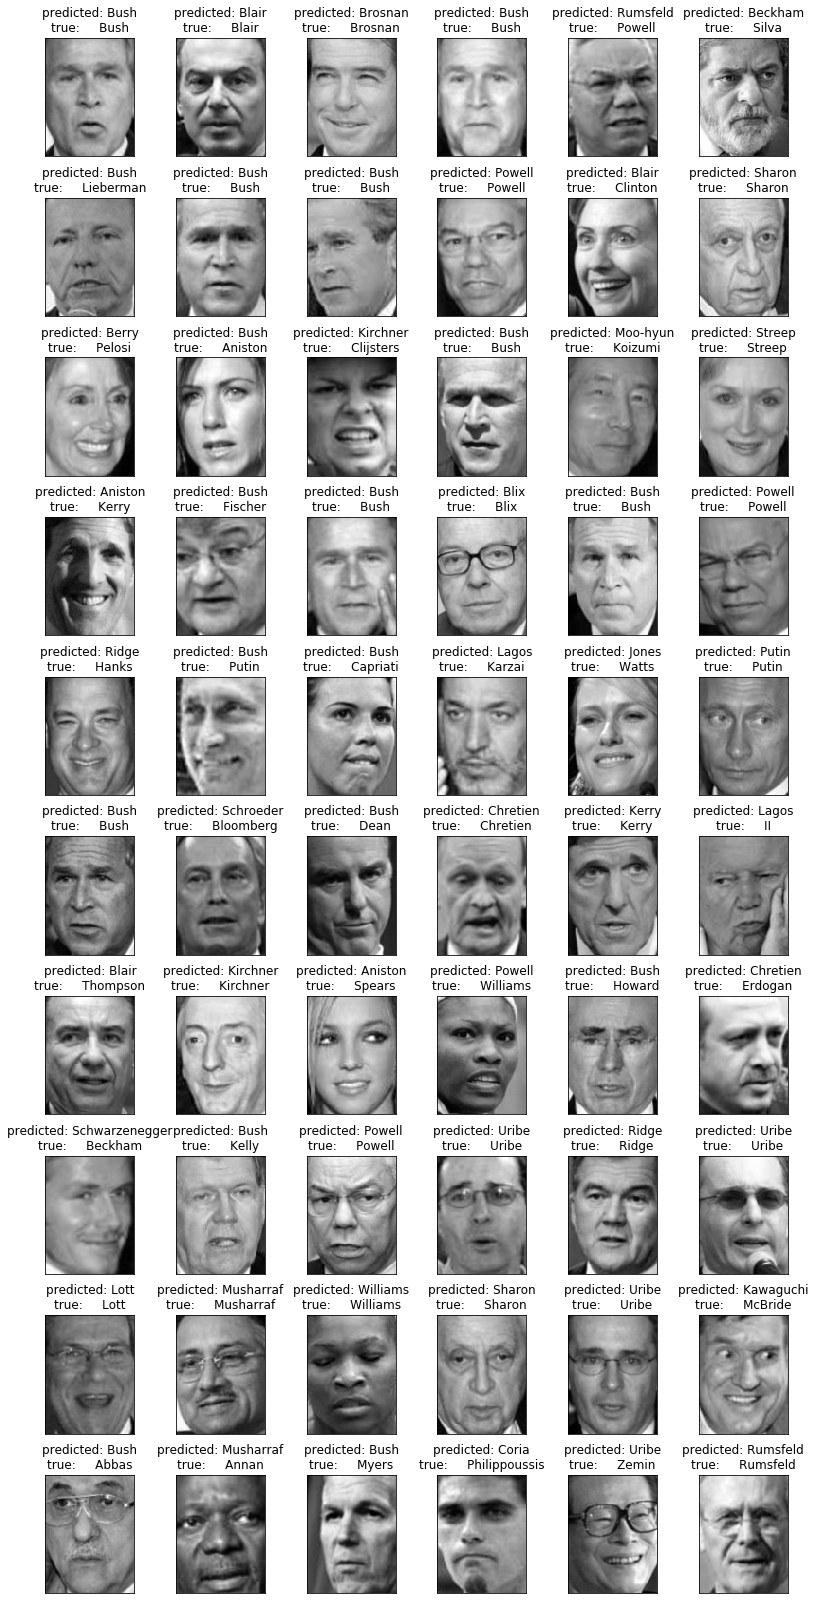

In [59]:
MLPC = neural_network.MLPClassifier(hidden_layer_sizes=(10000, ),
activation='relu', # {identity, logistic, tanh, relu},
solver='adam', # {lbfgs, sgd, adam},
alpha=0.0001,
learning_rate='constant', # {constant, invscaling, adaptive},
learning_rate_init=0.001,
power_t=0.5,
max_iter=1000,
shuffle=True,
tol=0.00001,
verbose=True,
momentum=0.9,
validation_fraction=0.1)


MLPC.fit(X_train_pca,y_train)
y_pred = MLPC.predict(X_test_pca)


print(classification_report(y_test, y_pred, target_names=target_names))
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:     %s'%(pred_name, true_name)
 
prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]
 
plot_gallery(X_test, prediction_titles, height, width ,10, 6)
plt.show()

In [60]:
scores = cross_val_score(MLPC,X_train_pca,y_train)
np.mean(scores)

Iteration 1, loss = 4.46387852
Iteration 2, loss = 2.05478517
Iteration 3, loss = 0.81871968
Iteration 4, loss = 0.28235984
Iteration 5, loss = 0.09975213
Iteration 6, loss = 0.04738080
Iteration 7, loss = 0.02901025
Iteration 8, loss = 0.02111607
Iteration 9, loss = 0.01693997
Iteration 10, loss = 0.01427937
Iteration 11, loss = 0.01242002
Iteration 12, loss = 0.01094838
Iteration 13, loss = 0.00980414
Iteration 14, loss = 0.00885360
Iteration 15, loss = 0.00805911
Iteration 16, loss = 0.00736879
Iteration 17, loss = 0.00677806
Iteration 18, loss = 0.00626244
Iteration 19, loss = 0.00581454
Iteration 20, loss = 0.00540981
Iteration 21, loss = 0.00506421
Iteration 22, loss = 0.00474571
Iteration 23, loss = 0.00446676
Iteration 24, loss = 0.00420973
Iteration 25, loss = 0.00398114
Iteration 26, loss = 0.00377052
Iteration 27, loss = 0.00358231
Iteration 28, loss = 0.00341017
Iteration 29, loss = 0.00325010
Iteration 30, loss = 0.00310549
Iteration 31, loss = 0.00297240
Iteration 32, los

Iteration 82, loss = 0.00104464
Iteration 83, loss = 0.00103443
Iteration 84, loss = 0.00102426
Iteration 85, loss = 0.00101423
Iteration 86, loss = 0.00100464
Iteration 87, loss = 0.00099554
Iteration 88, loss = 0.00098663
Training loss did not improve more than tol=0.000010 for two consecutive epochs. Stopping.


0.47623622696467427